In [1]:
import os

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from typing import Sequence

# install and import ltv
!pip install -q git+https://github.com/google/lifetime_value
import lifetime_value as ltv

     |████████████████████████████████| 462 kB 13.0 MB/s 


In [2]:
tfd = tfp.distributions
%config InlineBackend.figure_format='retina'
sns.set_style('whitegrid')

## Configs

In [3]:
MODEL = 'dnn'
LOSS = 'ziln' # @param { isTemplate: true, type: 'string'} ['mse', 'ziln']
LEARNING_RATE = 0.001  # @param { isTemplate: true}
VERSION = 0 # @param { isTemplate: true, type: 'integer'}
OUTPUT_CSV_FOLDER = '/tmp/lifetime-value/kdd_cup_98/result' # @param { isTemplate: true, type: 'string'}

## Load data

Download kdd_cup_98 data to /tmp/lifetime-value/kdd_cup_98

In [4]:
%%shell
mkdir -p /tmp/lifetime-value/kdd_cup_98
wget https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup98-mld/epsilon_mirror/cup98lrn.zip -P /tmp/lifetime-value/kdd_cup_98/
wget https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup98-mld/epsilon_mirror/cup98val.zip -P /tmp/lifetime-value/kdd_cup_98/
wget https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup98-mld/epsilon_mirror/valtargt.txt -P /tmp/lifetime-value/kdd_cup_98/
cd /tmp/lifetime-value/kdd_cup_98/
unzip cup98lrn.zip
unzip cup98val.zip

--2022-02-15 17:42:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup98-mld/epsilon_mirror/cup98lrn.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36468735 (35M) [application/x-httpd-php]
Saving to: ‘/tmp/lifetime-value/kdd_cup_98/cup98lrn.zip’

cup98lrn.zip        100%[===================>]  34.78M  12.8MB/s    in 2.7s    

2022-02-15 17:42:51 (12.8 MB/s) - ‘/tmp/lifetime-value/kdd_cup_98/cup98lrn.zip’ saved [36468735/36468735]

--2022-02-15 17:42:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup98-mld/epsilon_mirror/cup98val.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36763018 (35M) [application/x-httpd

In [5]:
df_train = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/cup98LRN.txt')
num_train = df_train.shape[0]
df_eval = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/cup98VAL.txt')
df_eval_target = pd.read_csv('/tmp/lifetime-value/kdd_cup_98/valtargt.txt')
df_eval = df_eval.merge(df_eval_target, on='CONTROLN')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
df = pd.concat([df_train, df_eval], axis=0, sort=True)

## Label distribution

In [55]:
y = df['TARGET_D'][:num_train]
# x = df.iloc[:, 1:-1].values
# y = df.iloc[:, 2].values

In [50]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 1/3 , random_state = 0)

In [53]:
# from sklearn.linear_model import LinearRegression
# regressor = LinearRegression()
# regressor.fit(x_train,y_train)

In [56]:
def plot_hist_log_scale(y):
  max_val = y.max() + 1. 
  ax = pd.Series(y).hist(
      figsize=(8, 5), bins = 10 ** np.linspace(0., np.log10(max_val), 20))

  plt.xlabel('Donation ($)')
  plt.ylabel('Count')
  # plt.title('Histogram of LTV')
  plt.xticks(rotation='horizontal')
  plt.legend(loc='upper left')
  ax.set_xscale('log')
  ax.grid(False)
  # Hide the right and top spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  # Only show ticks on the left and bottom spines
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')
  plt.show()

  fig = ax.get_figure()
  output_file = tf.io.gfile.GFile(
          '/tmp/lifetime-value/kdd_cup_98/histogram_kdd98_log_scale.pdf',
          'wb')
  fig.savefig(output_file, bbox_inches='tight', format='pdf')

No handles with labels found to put in legend.


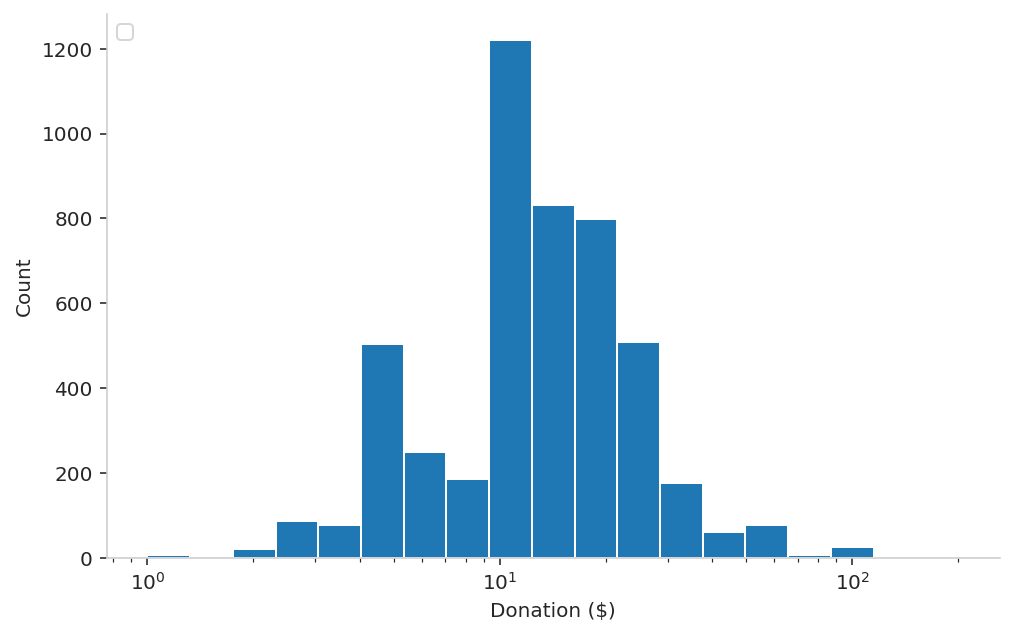

In [9]:
plot_hist_log_scale(y[y>0])

### Vocab

In [10]:
VOCAB_FEATURES = [
    'ODATEDW',  # date of donor's first gift (YYMM)
    'OSOURCE',  # donor acquisition mailing list
    'TCODE',    # donor title code
    'STATE',
    'ZIP',
    'DOMAIN',   # urbanicity level and socio-economic status of the neighborhood
    'CLUSTER',  # socio-economic status
    'GENDER',
    'MAXADATE', # date of the most recent promotion received
    'MINRDATE',
    'LASTDATE',
    'FISTDATE',
    'RFA_2A',
]

In [11]:
df['ODATEDW'] = df['ODATEDW'].astype('str')
df['TCODE'] = df['TCODE'].apply(
    lambda x: '{:03d}'.format(x // 1000 if x > 1000 else x))
df['ZIP'] = df['ZIP'].str.slice(0, 5)
df['MAXADATE'] = df['MAXADATE'].astype('str')
df['MINRDATE'] = df['MINRDATE'].astype('str')
df['LASTDATE'] = df['LASTDATE'].astype('str')
df['FISTDATE'] = df['FISTDATE'].astype('str')

In [12]:
def label_encoding(y, frequency_threshold=100):
  value_counts = pd.value_counts(y)
  categories = value_counts[
      value_counts >= frequency_threshold].index.to_numpy()
  # 0 indicates the unknown category.
  return pd.Categorical(y, categories=categories).codes + 1

In [13]:
for key in VOCAB_FEATURES:
  df[key] = label_encoding(df[key])

### Indicator

In [14]:
MAIL_ORDER_RESPONSES = [
    'MBCRAFT',
    'MBGARDEN',
    'MBBOOKS',
    'MBCOLECT',
    'MAGFAML',
    'MAGFEM',
    'MAGMALE',
    'PUBGARDN',
    'PUBCULIN',
    'PUBHLTH',
    'PUBDOITY',
    'PUBNEWFN',
    'PUBPHOTO',
    'PUBOPP',
    'RFA_2F',
]

In [15]:
INDICATOR_FEATURES = [
    'AGE',  # age decile, 0 indicates unknown
    'NUMCHLD',
    'INCOME',
    'WEALTH1',
    'HIT',
] + MAIL_ORDER_RESPONSES

In [16]:
df['AGE'] = pd.qcut(df['AGE'].values, 10).codes + 1
df['NUMCHLD'] = df['NUMCHLD'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['INCOME'] = df['INCOME'].apply(lambda x: 0 if np.isnan(x) else int(x))
df['WEALTH1'] = df['WEALTH1'].apply(lambda x: 0 if np.isnan(x) else int(x) + 1)
df['HIT'] = pd.qcut(df['HIT'].values, q=50, duplicates='drop').codes

for col in MAIL_ORDER_RESPONSES:
  df[col] = pd.qcut(df[col].values, q=20, duplicates='drop').codes + 1

### Numeric

In [17]:
NUMERIC_FEATURES = [
    # binary
    'MAILCODE',  # bad address
    'NOEXCH',    # do not exchange
    'RECINHSE',  # donor has given to PVA's in house program
    'RECP3',     # donor has given to PVA's P3 program
    'RECPGVG',   # planned giving record
    'RECSWEEP',  # sweepstakes record
    'HOMEOWNR',  # home owner
    'CHILD03',
    'CHILD07',
    'CHILD12',
    'CHILD18',

    # continuous
    'CARDPROM',
    'NUMPROM',
    'CARDPM12',
    'NUMPRM12',
    'RAMNTALL',
    'NGIFTALL',
    'MINRAMNT',
    'MAXRAMNT',
    'LASTGIFT',
    'AVGGIFT',
]

In [18]:
df['MAILCODE'] = (df['MAILCODE'] == 'B').astype('float32')
df['PVASTATE'] = df['PVASTATE'].isin(['P', 'E']).astype('float32')
df['NOEXCH'] = df['NOEXCH'].isin(['X', '1']).astype('float32')
df['RECINHSE'] = (df['RECINHSE'] == 'X').astype('float32')
df['RECP3'] = (df['RECP3'] == 'X').astype('float32')
df['RECPGVG'] = (df['RECPGVG'] == 'X').astype('float32')
df['RECSWEEP'] = (df['RECSWEEP'] == 'X').astype('float32')
df['HOMEOWNR'] = (df['HOMEOWNR'] == 'H').astype('float32')
df['CHILD03'] = df['CHILD03'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD07'] = df['CHILD07'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD12'] = df['CHILD12'].isin(['M', 'F', 'B']).astype('float32')
df['CHILD18'] = df['CHILD18'].isin(['M', 'F', 'B']).astype('float32')

df['CARDPROM'] = df['CARDPROM'] / 100
df['NUMPROM'] = df['NUMPROM'] / 100
df['CARDPM12'] = df['CARDPM12'] / 100
df['NUMPRM12'] = df['NUMPRM12'] / 100
df['RAMNTALL'] = np.log1p(df['RAMNTALL'])
df['NGIFTALL'] = np.log1p(df['NGIFTALL'])
df['MINRAMNT'] = np.log1p(df['MINRAMNT'])
df['MAXRAMNT'] = np.log1p(df['MAXRAMNT'])
df['LASTGIFT'] = np.log1p(df['LASTGIFT'])
df['AVGGIFT'] = np.log1p(df['AVGGIFT'])

### All

In [19]:
CATEGORICAL_FEATURES = VOCAB_FEATURES + INDICATOR_FEATURES
ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

## Train/eval split

In [20]:
def dnn_split(df):
  df_train = df.iloc[:num_train]
  df_eval = df.iloc[num_train:]

  def feature_dict(df):
    features = {k: v.values for k, v in dict(df[CATEGORICAL_FEATURES]).items()}
    features['numeric'] = df[NUMERIC_FEATURES].astype('float32').values
    return features

  x_train, y_train = feature_dict(df_train), df_train['TARGET_D'].astype(
      'float32').values
  x_eval, y_eval = feature_dict(df_eval), df_eval['TARGET_D'].astype(
      'float32').values

  return x_train, x_eval, y_train, y_eval

## Model

In [21]:
def embedding_dim(x):
  return int(x**.25) + 1


def embedding_layer(vocab_size):
  return tf.keras.Sequential([
      tf.keras.layers.Embedding(
          input_dim=vocab_size,
          output_dim=embedding_dim(vocab_size),
          input_length=1),
      tf.keras.layers.Flatten(),
  ])


def dnn_model(output_units):
  numeric_input = tf.keras.layers.Input(
      shape=(len(NUMERIC_FEATURES),), name='numeric')

  embedding_inputs = [
      tf.keras.layers.Input(shape=(1,), name=key, dtype=np.int64)
      for key in CATEGORICAL_FEATURES
  ]

  embedding_outputs = [
      embedding_layer(vocab_size=df[key].max() + 1)(input)
      for key, input in zip(CATEGORICAL_FEATURES, embedding_inputs)
  ]

  deep_input = tf.keras.layers.concatenate([numeric_input] + embedding_outputs)
  deep_model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(units=output_units),
  ])
  return tf.keras.Model(
      inputs=[numeric_input] + embedding_inputs, outputs=deep_model(deep_input))

## Loss

In [22]:
if LOSS == 'mse':
  loss = tf.keras.losses.MeanSquaredError()
  output_units = 1

if LOSS == 'ziln':
  loss = ltv.zero_inflated_lognormal_loss
  output_units = 3

In [23]:
x_train, x_eval, y_train, y_eval = dnn_split(df)
model = dnn_model(output_units)

In [24]:
model.compile(optimizer=tf.keras.optimizers.Nadam(lr=LEARNING_RATE), loss=loss)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


## Train

In [25]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
]

In [26]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=2048,
    epochs=200,
    verbose=2,
    callbacks=callbacks,
    validation_data=(x_eval, y_eval)).history

Epoch 1/200
47/47 - 8s - loss: 0.4851 - val_loss: 0.3560 - lr: 0.0010 - 8s/epoch - 166ms/step
Epoch 2/200
47/47 - 2s - loss: 0.3574 - val_loss: 0.3546 - lr: 0.0010 - 2s/epoch - 33ms/step
Epoch 3/200
47/47 - 2s - loss: 0.3547 - val_loss: 0.3522 - lr: 0.0010 - 2s/epoch - 33ms/step
Epoch 4/200
47/47 - 2s - loss: 0.3539 - val_loss: 0.3519 - lr: 0.0010 - 2s/epoch - 32ms/step
Epoch 5/200
47/47 - 1s - loss: 0.3525 - val_loss: 0.3520 - lr: 0.0010 - 1s/epoch - 25ms/step
Epoch 6/200
47/47 - 1s - loss: 0.3510 - val_loss: 0.3600 - lr: 0.0010 - 1s/epoch - 26ms/step
Epoch 7/200
47/47 - 2s - loss: 0.3493 - val_loss: 0.3527 - lr: 0.0010 - 2s/epoch - 32ms/step
Epoch 8/200
47/47 - 2s - loss: 0.3488 - val_loss: 0.3594 - lr: 0.0010 - 2s/epoch - 32ms/step
Epoch 9/200
47/47 - 2s - loss: 0.3481 - val_loss: 0.3563 - lr: 0.0010 - 2s/epoch - 32ms/step
Epoch 10/200
47/47 - 2s - loss: 0.3474 - val_loss: 0.3657 - lr: 0.0010 - 2s/epoch - 32ms/step
Epoch 11/200
47/47 - 2s - loss: 0.3464 - val_loss: 0.3513 - lr: 0.00

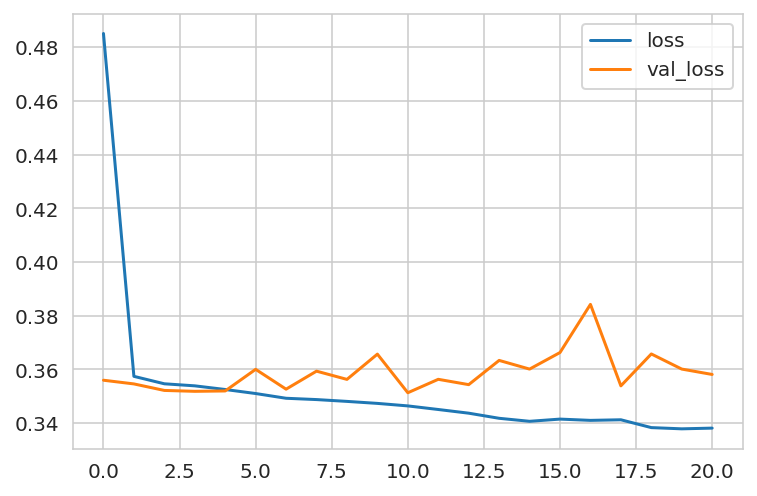

In [27]:
pd.DataFrame(history)[['loss', 'val_loss']].plot();

## Eval

In [28]:
if LOSS == 'mse':
  y_pred = model.predict(x=x_eval, batch_size=1024).flatten()

if LOSS == 'ziln':
  logits = model.predict(x=x_eval, batch_size=1024)
  y_pred = ltv.zero_inflated_lognormal_pred(logits).numpy().flatten()

### Total Profit

In [29]:
unit_costs = [0.4, 0.5, 0.6, 0.68, 0.7, 0.8, 0.9, 1.0]

In [30]:
num_mailed = [np.sum(y_pred > v) for v in unit_costs]
num_mailed

[90096, 80404, 67015, 55471, 52694, 39260, 27743, 18761]

In [31]:
baseline_total_profit = np.sum(y_eval - 0.68)
baseline_total_profit

10560.074

In [32]:
total_profits = [np.sum(y_eval[y_pred > v] - v) for v in unit_costs]
total_profits

[37133.24,
 28405.14,
 20239.139,
 15020.856,
 14103.342,
 9779.139,
 6935.0723,
 5350.95]

### Gini Coefficient

In [33]:
gain = pd.DataFrame({
    'lorenz': ltv.cumulative_true(y_eval, y_eval),
    'baseline': ltv.cumulative_true(y_eval, x_eval['numeric'][:, 19]),
    'model': ltv.cumulative_true(y_eval, y_pred),
})

In [34]:
num_customers = np.float32(gain.shape[0])
gain['cumulative_customer'] = (np.arange(num_customers) + 1.) / num_customers

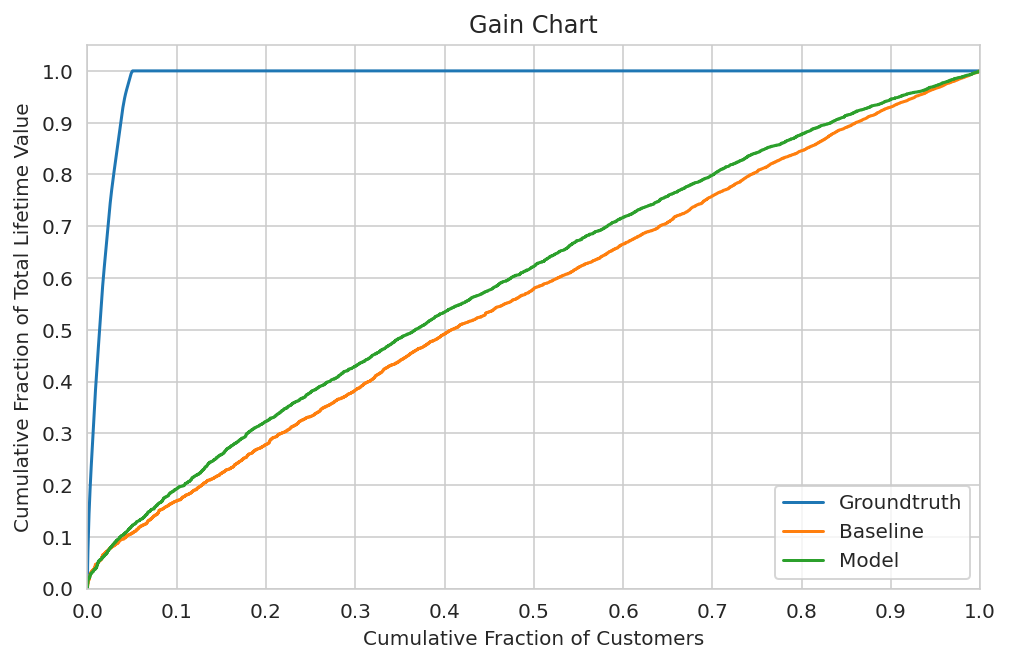

In [35]:
ax = gain[[
    'cumulative_customer',
    'lorenz',
    'baseline',
    'model',
]].plot(
    x='cumulative_customer', figsize=(8, 5), legend=True)

ax.legend(['Groundtruth', 'Baseline', 'Model'], loc='lower right')

ax.set_xlabel('Cumulative Fraction of Customers')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_xlim((0, 1.))

ax.set_ylabel('Cumulative Fraction of Total Lifetime Value')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim((0, 1.05))
ax.set_title('Gain Chart');

In [36]:
gini = ltv.gini_from_gain(gain[['lorenz', 'baseline', 'model']])
gini

,raw,normalized
lorenz,0.967057,1.000000
baseline,0.125138,0.129401
model,0.193120,0.199699


### Calibration

In [ ]:
df_decile = ltv.decile_stats(y_eval, y_pred)
df_decile

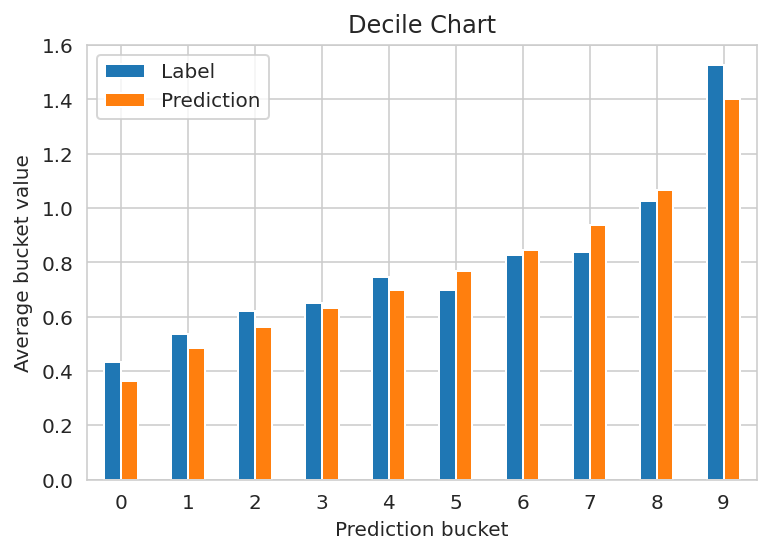

In [38]:
ax = df_decile[['label_mean', 'pred_mean']].plot.bar(rot=0)

ax.set_title('Decile Chart')
ax.set_xlabel('Prediction bucket')
ax.set_ylabel('Average bucket value')
ax.legend(['Label', 'Prediction'], loc='upper left');

### Rank Correlation

In [39]:
def spearmanr(
    x1: Sequence[float],
    x2: Sequence[float]) -> float:

  return stats.spearmanr(x1, x2, nan_policy='raise')[0]


spearman_corr = spearmanr(y_eval, y_pred)
spearman_corr

0.02529491487338011

### All metrics together

## Save

In [43]:
output_path = OUTPUT_CSV_FOLDER

In [44]:
if not os.path.isdir(output_path):
  os.makedirs(output_path)

In [45]:
output_file = os.path.join(output_path, '{}_regression_{}_{}.csv'.format(MODEL, LOSS, VERSION))

In [47]:
df_metrics.to_csv(output_file, index=False)